In [1]:
#DESIGN PARAMETERS FOR NEURAL NETWORK
NR_LSTM_UNITS = 2 
IMAGE_INPUT_SIZE_W = 640
IMAGE_INPUT_SIZE_H = 480

IMAGE_AFTER_CONV_SIZE_W = 18
IMAGE_AFTER_CONV_SIZE_H = 13
#for 3x3 kernels, n=num_layers: len_in = 2^n*len_out + sum[i=1..n](2^i)
#CONV_LAYER_LENGTH = 5

LSTM_IO_SIZE = 18*13
LSTM_HIDDEN_SIZE = 18*13

RGB_CHANNELS = 3
TIMESTEPS = 10 # size videos
BATCH_SIZE = 4 #until now just batch_size = 1

NR_EPOCHS = 1

VALIDATION_SPLIT = 0.2 #indicated ratio of training to validation data: 0.2 -> 20% VALIDATION data
RANDOMIZED_SEED = 20
SHUFFLE_DATASET = False

learning_rate = 0.01 # reduce factos of 10 .. some epoch later.
momentum = 0.9
print("Hyperparameters defined")

Hyperparameters defined


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import time
import os
import os.path as path
import copy
# from torch.utils.data.sampler import SequentialSampler


from gait_analysis import AnnotationsCasia as Annotations
from gait_analysis import CasiaDataset
from gait_analysis.Config import Config
from gait_analysis import Composer

import matplotlib.pyplot as plt

print("done")

done


In [3]:
#change configuration in settings.py
crop_im_size = [186,250]
c = Config()
c.config['indexing']['grouping'] = 'person_sequence_angle'
c.config['transformers']['DimensionResize']['dimension'] = TIMESTEPS
#c.config['indexing']['people selection'] = [1]
#c.config['indexing']['sequences_selection'] = ['nm-01']
c.config['pose']['load'] = False
c.config['flow']['load'] = True
c.config['heatmaps']['load'] = False
#c.config['scenes']['sequences'] = ['nm']
#c.config['scenes']['angles'] = ['108']
c.config['dataset_output'] = {
#         'data': ["scenes","flows","heatmaps_LAnkle","heatmaps_RAnkle"],
        'data': ['flows'],
        'label': "annotations"}
composer = Composer()
transformer = composer.compose()
dataset = CasiaDataset(transform=transformer)

loading configuration  flows
[OK]


# Settings 
## Dataset

In [4]:
dataset_size = len(dataset)
indices = list(range(dataset_size))
print("Dataset size:", len(dataset))
print("Indices size:", len(indices))
split = int(np.floor(VALIDATION_SPLIT * dataset_size))
print("Split:", split)
if SHUFFLE_DATASET:
    np.random.seed(RANDOMIZED_SEED)
    np.random.shuffle(indices)
train_indices, test_indices = indices[split:], indices[:split]
train_sampler = torch.utils.data.SequentialSampler(train_indices)
test_sampler = torch.utils.data.SequentialSampler(test_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, sampler=test_sampler)

# #

Dataset size: 5
Indices size: 5
Split: 1


## neural network

In [5]:
class TEST_CNN_LSTM(nn.Module):
    def __init__(self):
        super(TEST_CNN_LSTM, self).__init__()
        self.avialable_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        self.conv1 = nn.Conv2d(3,6,3) #input 640x480
        self.pool1 = nn.MaxPool2d(2,2) #input 638x478 output 319x239
        self.conv2 = nn.Conv2d(6,16,3) # input 319x239 output 317x237
        self.pool2 = nn.MaxPool2d(2,2) # input 317x237 output 158x118
        self.conv3 = nn.Conv2d(16,6,3) # input 158x118 output 156x116
        self.pool3 = nn.MaxPool2d(2,2) # input 156x116 output 78x58
        self.conv4 = nn.Conv2d(6,3,3)  # input 78x58 output 76x56
        self.pool4 = nn.MaxPool2d(2,2) # input 76x56 output 39x29
        self.conv5 = nn.Conv2d(3,1,3)  # input 39x29 output 37x27
        self.pool5 = nn.MaxPool2d(2,2) #output 37x27 output 18x13
        self.lstm1 = nn.LSTM(LSTM_IO_SIZE,
                            LSTM_HIDDEN_SIZE,
                            TIMESTEPS)# horizontal direction
        self.lstm2 = nn.LSTM(LSTM_IO_SIZE,
                            LSTM_HIDDEN_SIZE,
                            TIMESTEPS)# horizontal direction
        self.fc1 = nn.Linear(LSTM_IO_SIZE,120)
        self.fc2 = nn.Linear(120,20)
        self.fc3 = nn.Linear(20,3)
        
        #initialize hidden states of LSTM
        self.hidden = self.init_hidden()

        #print("Hidden:", _hidden)
    def init_hidden(self):
        return (torch.randn(TIMESTEPS, BATCH_SIZE, LSTM_HIDDEN_SIZE).to(self.avialable_device), 
                torch.randn(TIMESTEPS, BATCH_SIZE, LSTM_HIDDEN_SIZE).to(self.avialable_device))
    def forward(self,x):
#         print("Input list len:",len(x))
#         print("Input elemens size:", x[0].size())
#         batch_size = x[0].size()[0]

        x_arr = torch.zeros(TIMESTEPS,BATCH_SIZE,1,IMAGE_AFTER_CONV_SIZE_H,IMAGE_AFTER_CONV_SIZE_W).to(self.avialable_device)
        #print("X arr size", x_arr.size())
        #print("X size", len(x))
        for i in range(TIMESTEPS):#parallel convolutions which are later concatenated for LSTM
            x_tmp_c1 = self.pool1(F.relu(self.conv1(x[i].float())))
            x_tmp_c2 = self.pool2(F.relu(self.conv2(x_tmp_c1)))
            x_tmp_c3 = self.pool3(F.relu(self.conv3(x_tmp_c2)))
            x_tmp_c4 = self.pool4(F.relu(self.conv4(x_tmp_c3)))
            x_tmp_c5 = self.pool5(F.relu(self.conv5(x_tmp_c4)))
            x_arr[i] = x_tmp_c5 # torch.squeeze(x_tmp_c5)
        
        x, hidden = self.lstm1(x_arr.view(TIMESTEPS,BATCH_SIZE,-1), self.hidden)
        x, hidden = self.lstm2(x, self.hidden)
        # the reshaping was taken from the documentation... and makes scense
        x = x.view(TIMESTEPS,BATCH_SIZE,LSTM_HIDDEN_SIZE) #output.view(seq_len, batch, num_dir*hidden_size)
#         x = torch.squeeze(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x) 
        #x = x.squeeze(1)
        x = x.permute(1,2,0)
        #print ("Size network output", x.shape)
        return x
print("Class defined")

Class defined


In [23]:
### define and execute testing function
def test_all_preds(model):
    n_batches_test = len(test_loader)

    #Time for printing
    testing_start_time = time.time()

    print('Start testing...')
    correct = 0 
    total = 0
    with torch.no_grad():
        for i, batch in enumerate(train_loader):
            inputs, labels = batch
            
            data_in = [s.to(device) for s in inputs['flows']]
            labels = labels.to(device)
            if not labels.size()[0] == BATCH_SIZE:
                # skip uncompleted batch size NN is fixed to BATCHSIZE
                continue
            outputs = model(data_in)
#             print("Out:", len(outputs), outputs.size())
#             print("Labels:", len(labels), labels.size())
            _, predicted = torch.max(outputs.data, 1)
#             print('predicted:',len(predicted),predicted.size())
            n_errors = torch.nonzero(torch.abs(labels.long() - predicted)).size(0)
            total += predicted.numel()
            # print('predicted',predicted)
            correct += predicted.numel() - n_errors
            # print('labels',labels)
    print('Accuracy {:.2f}%'.format(100*correct/total))
    print('...testing finished')
print("Definition done")

Definition done


### Test-Training

In [7]:
#TRAINING
test_net = TEST_CNN_LSTM()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
test_net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(test_net.parameters(), lr=learning_rate, momentum=momentum)


cpu


### Test set and evaluate computing time etc.

In [8]:
start_time = time.time()

print('Start training...')
print("Expected loss with {} different classes and {} data elements: {}".format(3, len(dataset)-split, (len(dataset)-split)*np.log(3)))
running_loss = 0.0
#print("Data set length:", len((train_loader)), "Validation length:", len(test_loader))
print("Batch size:", BATCH_SIZE)
print("Evaluating first element...")
start_time = time.time()
i, batch = next(iter(enumerate(train_loader)))
inputs, labels = batch
data_in = [s.to(device) for s in inputs['flows']]
labels = labels.to(device)
print("Time steps:{}, input sequence length:{}".format(TIMESTEPS,len(data_in)))
#print("NN input: ",len(flows),len(flows[0]),len(flows[0][0]),len(flows[0][0][0]),len(flows[0][0][0][0]))
optimizer.zero_grad() 
outputs = test_net(data_in)
print("Expected output format: [BATCH, NR_CLASSES, TIMESTEPS]")
print("Output format:", len(outputs), outputs.size())
print("Expected label format: [BATCH, TIMESTEPS] (with int-label as each element indicating the correct one)")
print("Labels:", len(labels), labels.size())
#print("Labels content:", labels)
loss = criterion(outputs.float(),labels.long())
loss.backward() 
optimizer.step()

running_loss += loss.data.item()
elapsed_time = time.time() - start_time;
print("Loss:{}, expected loss:{}".format(running_loss, np.log(3)))
print("Time needed:{}s".format(elapsed_time))
print("Expected loss for total training data: ", (len(dataset)-split)*np.log(3))
print("Expected training time per epoch:{} min".format(elapsed_time* len(train_loader)/60))
print("Estimated total training time:{} hours".format(elapsed_time* len(train_loader)*NR_EPOCHS/3600))

Start training...
Expected loss with 3 different classes and 4 data elements: 4.394449154672439
Batch size: 4
Evaluating first element...


/home/matthias/.conda/envs/gait_37/lib/python3.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


Time steps:10, input sequence length:10
Out: 4 torch.Size([4, 3, 10])
Labels: 4 torch.Size([4, 10])
Loss:1.088744044303894, expected loss:1.0986122886681098
Time needed:33.65627980232239s
Expected loss for total training data:  4.394449154672439
Expected training time per epoch:0.5609379967053731 min
Estimated total training time:0.009348966611756219 hours


In [9]:
#PREPARATION FOR TRAINING
loss_array = []
learning_rate_array = []

### Start Training here

Epoch: 0
Loss epoch 0: 1.087401270866394, took 17.441821336746216s
...Training finished


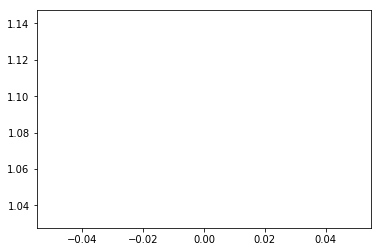

In [10]:
for epoch in range(NR_EPOCHS): 
    running_loss = 0.0
    start_time = time.time()
    print("Epoch:", epoch)
    running_loss = 0.0
    for i, batch in enumerate(train_loader):
        inputs, labels = batch
        data_in = [s.to(device) for s in inputs['flows']]
        labels = labels.to(device)
        
        optimizer.zero_grad() 
        
        outputs = test_net(data_in)
        loss = criterion(outputs.float(),labels.long())
        loss.backward() 
        optimizer.step()
        
        running_loss += loss.data.item()

    print("Loss epoch {}: {}, took {}s".format(epoch, running_loss,time.time()-start_time))
    loss_array.append(running_loss)
    learning_rate_array.append(learning_rate)

#test_all_preds(test_net) 
print('...Training finished')
plt.plot(loss_array)

In [11]:
#DYNAMIC CHANGES:
NR_EPOCHS = 100
learning_rate = 0.01
momentum = 0.9
optimizer = optim.SGD(test_net.parameters(), lr=learning_rate, momentum=momentum)

Expected loss:4.394449154672439, last loss:1.087401270866394
Batch size: 4
Sequence length: 10
Total epochs learnt: 1
Start testing...
Accuracy 35.00%
...testing finished


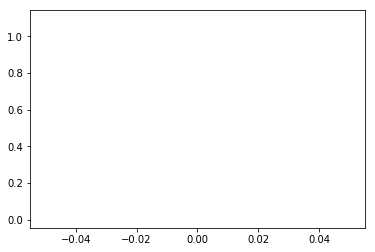

In [25]:
#EVALUATION
print("Expected loss:{}, last loss:{}".format((len(dataset)-split)*np.log(3),loss_array[-1]))
print("Batch size:", BATCH_SIZE)
print("Sequence length:",TIMESTEPS)
print("Total epochs learnt:", len(loss_array))
plt.plot(learning_rate)
plt.plot(loss_array)
test_all_preds(test_net)


### Expected loss for untrained set with Cross Entropy:
k = number of classes
N = number of labeled data in dataset
loss_per_prediction = -log(1/k) = log(k)
total_loss = sum(log(k)) = N*log(k)

In [20]:
len(dataset)-split

4